## Нелинейные алгебраические уравнения и системы

Нелиненые алгебраические уравнения естественным образом возникают в прикладных задачах, а также в результате дискретизации неявных схем для дифференциальных уравнений в частных производных. Для решения этих уравнений применяются итерационные методы, так как прямые методы существуют лишь для ограниченного класса уравнений.

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=14)
plt.rc('figure', figsize=(12, 7))

### Метод дихотомии
Простейший и достаточно надежный метод отыскания корня скалярного уравнения $f(x) = 0$ заключается в дроблении отрезка локализации корня пополам. Метод сходится линейной с фиксированной скоростью $q = \frac{1}{2}$ (ошибка стремится к нулю как $q^k$, где $k$ &mdash; номер итерации). Единственное требование, предъявляемое к $f(x)$  &mdash; непрерывность на отрезке $[a,b]$.

In [2]:
def bisection(f, a, b, eps=1e-8):
    fa = f(a)
    fb = f(b)
    k = 0
    assert fa * fb <= 0, 'Знаки f(a)=%g и f(b)=%g должны отличаться!' % (fa, fb)
    while b - a > 2*eps:
        c = (a+b) / 2    # Находим середину отрезка и значение f(x) в середине отрезка
        fc = f(c)
        k += 1
        if fa * fc <= 0: # Если на левой половине знаки разные
            b = c
            fb = fc      # Сокращаем отрезок до [a, c]
        else:            
            a = c
            fa = fc      # Иначе сокращаем до [c, b]
    print('Отрезок локализации после', k, 'итераций: [', a,',', b, ']')
    return (a+b) / 2

Рассмотрим уравнение Ван-дер-Ваальса в приведенных переменных $\varphi = \frac{V}{V_\text{cr}}, \pi = \frac{p}{p_\text{cr}}, \tau = \frac{T}{T_\text{cr}}$:
$$
\left(\pi + \frac{3}{\varphi^2}\right)\left(\varphi - \frac{1}{3}\right) = \frac{8}{3} \tau
$$
При фиксированных $\pi, \tau$ этому уравнению могут удовлетворять три значения $\varphi$. Возьмем $\tau = 0.9, \pi = 0.6$

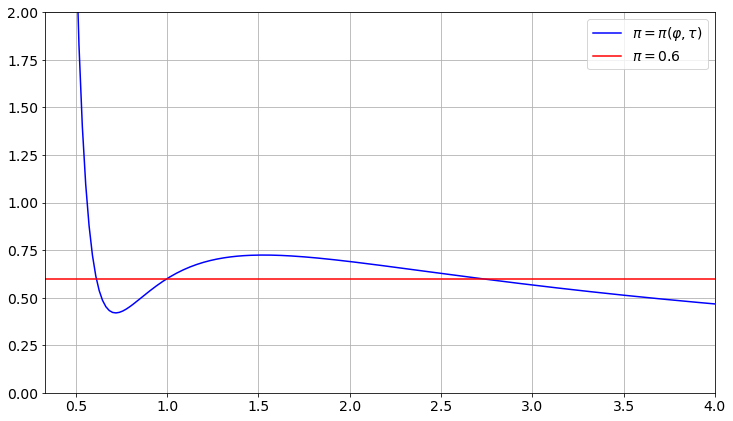

In [3]:
def vdv(tau, phi):
    return -3 / phi**2 + 8*tau / 3 / (phi - 1/3)

tau = 0.9
pi = 0.6

phi = np.linspace(1/3 + 1e-6, 4, 200)
plt.plot(phi, vdv(tau, phi), 'b', label=r'$\pi = \pi(\varphi, \tau)$')
plt.plot(phi, pi*np.ones_like(phi), 'r', label=r'$\pi = 0.6$')
plt.legend(loc='upper right')
plt.xlim(1/3, 4)
plt.ylim(0, 2)
plt.grid();

Имеется 3 корня $\varphi_1 \in [0.5, 0.75]$ (жидкая фаза), $\varphi_2 \in [2.5, 3.0]$ (газовая фаза), $\varphi_3 \in [0.9, 1.1]$ (нестабильное состояние, нефизичный корень).

In [4]:
# Решаем уравнение vdv(tau, phi) - pi = 0 относительно phi

# Жидкая фаза
phiLiquid = bisection(lambda phi: vdv(tau, phi) - pi, 0.5, 0.75)

# Газовая фаза
phiGas    = bisection(lambda phi: vdv(tau, phi) - pi, 2.5, 3.0)

Отрезок локализации после 24 итераций: [ 0.6125741004943848 , 0.612574115395546 ]
Отрезок локализации после 25 итераций: [ 2.7207592129707336 , 2.720759227871895 ]


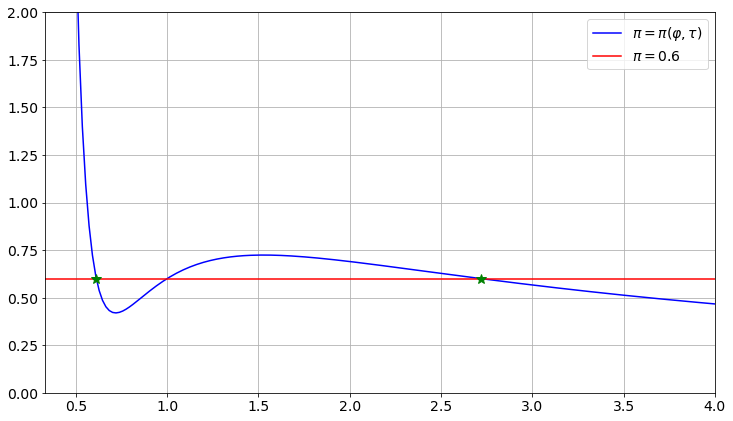

In [5]:
plt.plot(phi, vdv(tau, phi), 'b', label=r'$\pi = \pi(\varphi, \tau)$')
plt.plot(phi, pi*np.ones_like(phi), 'r', label=r'$\pi = 0.6$')
plt.plot([phiLiquid, phiGas], [pi, pi], 'g*', markersize=10)
plt.legend(loc='upper right')
plt.xlim(1/3, 4)
plt.ylim(0, 2)
plt.grid();

Однако метод дихотомии сходится достаточно медленно для практических применений, особенно, если нелинейное уравнение приходится решать очень часто (например, решать уравнение состояния в каждой ячейке расчетной области на каждом шаге по времени). В этом случае линейная сходимость со скоростью $q = 1/2$ может быть недостаточной.

Очень часто на практике для решения нелинейных задач (не обязательно алгебраических уравнений!) используют метод Ньютона. В основе метода Ньютона для нелинейной задачи используются вспомогательные более простые линейные задачи.

Пусть $x_n$ &mdash; некоторое приближение к решению $f(x) = 0$. Заменим нелинейное уравнение $f(x) = 0$ на похожее линейное. Для этого линеаризуем его в окрестности $x = x_n$:
$$
f(x) \approx f(x_n) + f'(x_n) (x - x_n)
$$
Решить уравнение $f(x_n) + f'(x_n) (x - x_n) = 0$ гораздо проще, чем исходное $f(x) = 0$, однако его решение является лишь приближенным решением $f(x) = 0$, хотя и более точным, чем $x_n$. При разумном поведении функции $f(x)$ выполняется
$$
|x_{n+1} - x^*| \leqslant C |x_n - x^*|^2.
$$
Такая сходимость называется квадратичной и характеризуется тем фактом, что на каждой итерации число верных цифр в решении примерно удваивается (в отличие от линейной сходимости, где на каждой итерации добавлялось фиксированное число верных цифр)

С точки вычислительной устойчивости одну итерацию метода Ньютона лучше проводить в два этапа:
* Найти приращение $\Delta x_{n+1}$ из уравнения
$$
f'(x_n) \cdot \Delta x_{n+1} = f(x_n).
$$
Отметим, что в точке $x_n$ необходимо знать не только $f(x)$, но еще и $f'(x)$.
* Вычесть приращение $\Delta x_{n+1}$. Если $|\Delta x_{n+1}| \leqslant \varepsilon$, закончить.
$$
x_{n+1} = x_n - \Delta x_{n+1}
$$

Метод Ньютона может разойтись в случае, если начальное приближение далеко от корня, может «застрять», не сходясь и не расходясь. В этом случае имеет смысл ограничить максимальное число итераций метода Ньютона. Для практических задач хватает не более 5-10 итераций метода.

In [6]:
def newton(f, x0, eps=1e-14, maxiter=10, verbose=False):
    x = x0
    for i in range(maxiter):
        fv, fp = f(x)   # Функция возвращает и f(x) и f'(x) одновременно
        dx = fv / fp
        x -= dx
        if verbose:
            print('Итерация %d, x = %e, dx = %e' % (i, x, dx))
        if abs(dx) < eps:
            return x
    raise RuntimeError('Метод не сошелся за %d итераций' % maxiter)

Допишем вычисление производной к уравнению состояния Ван-дер-Ваальса. При этом легко ошибиться, особенно для систем нелинейных уравнений. Так что лучше верифицировать значение производной численно.

In [7]:
def vdv_with_der(tau, phi):
    pi = -3 / phi**2 + 8*tau / 3 / (phi - 1/3)
    dpi_dphi = 6 / phi**3 - 8*tau / 3 / (phi - 1/3)**2
    return pi, dpi_dphi

In [8]:
def verify_der(h = 1e-5):
    tau0 = 0.9
    phi0 = 0.6
    
    v0, p0 = vdv_with_der(tau0, phi0) 
    
    vplus , _ = vdv_with_der(tau0, phi0 + h)
    vminus, _ = vdv_with_der(tau0, phi0 - h)
    
    # Формула симметричной разности, должна иметь порядок O(h^2)
    p_num = (vplus - vminus) / (2*h)
    
    print('Аналитическая производная:', p0)
    print('Численная производная:    ', p_num)
    print('Отклонение:               ', abs(p0 - p_num))
    
for h in [1e-4, 1e-5, 1e-6]:
    print('h = ', h)
    verify_der(h)

h =  0.0001
Аналитическая производная: -5.972222222222218
Численная производная:     -5.972225425106004
Отклонение:                3.202883785746735e-06
h =  1e-05
Аналитическая производная: -5.972222222222218
Численная производная:     -5.972222254246872
Отклонение:                3.202465403973065e-08
h =  1e-06
Аналитическая производная: -5.972222222222218
Численная производная:     -5.972222222538903
Отклонение:                3.1668534461459785e-10


С производной, похоже, все в порядке. Решим исходное уравнение, но теперь уже методом Ньютона вместо дихотомии. Единственное, нужно привести уравнение $\text{vdv}(\tau, \varphi) = \pi$ к виду $f(\varphi) = 0$

In [9]:
def f(phi):
    lhs_val, lhs_der = vdv_with_der(tau, phi)
    return lhs_val - pi, lhs_der

# Жидкая фаза
phiLiquid = newton(f, 0.6, verbose=True)
print(phiLiquid)

# Газовая фаза
phiGas = newton(f, 2.5, verbose=True)
print(phiGas)

Итерация 0, x = 6.111628e-01, dx = -1.116279e-02
Итерация 1, x = 6.125546e-01, dx = -1.391841e-03
Итерация 2, x = 6.125741e-01, dx = -1.947770e-05
Итерация 3, x = 6.125741e-01, dx = -3.757259e-09
Итерация 4, x = 6.125741e-01, dx = -4.985136e-16
0.6125741132772067
Итерация 0, x = 2.717634e+00, dx = -2.176339e-01
Итерация 1, x = 2.720758e+00, dx = -3.124334e-03
Итерация 2, x = 2.720759e+00, dx = -9.579160e-07
Итерация 3, x = 2.720759e+00, dx = -9.104616e-14
Итерация 4, x = 2.720759e+00, dx = -9.014471e-16
2.7207592200561272


Иногда функция бывает настолько сложной, либо вообще заданной не аналитическим выражением. В этом случае производную приходится как-то аппроксимировать. Здесь имеется две стратегии:
* Использовать $f(x_{n-1})$ для аппроксимации производной (метод секущих)
$$
f'(x_n) \approx \frac{f(x_n) - f(x_{n-1})}{x_n - x_{n-1}}
$$
При этом никаких новых вычислений $f(x)$ не требуется. Обобщить этот подход на системы уравнений довольно сложно, но возможно.
* Вычислить производную численно с фиксированным шагом
$$
f'(x_n) \approx \frac{f(x_n + h) - f(x_n)}{h}
$$
либо
$$
f'(x_n) \approx \frac{f(x_n + h) - f(x_n - h)}{2h}
$$
При этом количество вычислений функции на одну итерацию выростает вдвое и втрое соответственно (в случае систем все гораздо хуже).

In [10]:
def secant(f, x0, eps=1e-14, maxiter=10, h=1e-5, verbose=False):
    xp = x0     # xp - это x_{n-1}, xn - это x_n
    xn = x0 + h # Методу требуется хотя бы две точки, чтобы начать
    fp = f(xp)
    for i in range(maxiter):
        # Вычисляем только f(x_n), так как f(x_{n-1}) считали на прошлой итерации цикла
        fn = f(xn)
        f_der = (fn - fp) / (xn - xp) 
        
        dx = fn / f_der
        
        xp = xn # Запоминаем текущие значения в качестве предыдущих для следующей итерации
        fp = fn
        
        xn -= dx
        if verbose:
            print('Итерация %d, x = %e, dx = %e' % (i, xn, dx))
        if abs(dx) < eps:
            return xn
    raise RuntimeError('Метод не сошелся за %d итераций' % maxiter)    

In [11]:
# В secant передаем функцию, которая возвращает только значение, без производной

# Жидкая фаза
phiLiquid = secant(lambda phi: vdv(tau, phi) - pi, 0.6, verbose=True)
print(phiLiquid)

# Газовая фаза
phiGas = secant(lambda phi: vdv(tau, phi) - pi, 2.5, verbose=True)
print(phiGas)

Итерация 0, x = 6.111639e-01, dx = -1.115386e-02
Итерация 1, x = 6.124089e-01, dx = -1.245039e-03
Итерация 2, x = 6.125718e-01, dx = -1.629249e-04
Итерация 3, x = 6.125741e-01, dx = -2.287445e-06
Итерация 4, x = 6.125741e-01, dx = -3.745306e-09
Итерация 5, x = 6.125741e-01, dx = -8.519835e-14
Итерация 6, x = 6.125741e-01, dx = 2.601931e-16
0.6125741132772066
Итерация 0, x = 2.717634e+00, dx = -2.176240e-01
Итерация 1, x = 2.720703e+00, dx = -3.068521e-03
Итерация 2, x = 2.720759e+00, dx = -5.665754e-05
Итерация 3, x = 2.720759e+00, dx = -1.740508e-08
Итерация 4, x = 2.720759e+00, dx = -9.645484e-14
Итерация 5, x = 2.720759e+00, dx = -9.091260e-16
2.7207592200561272


Видим, что в данном случае сходимость чуть медленнее, чем для метода Ньютона с аналитической производной.

Посмотрим на второй способ &mdash; численно аппркосимируем производную конечной разностью. Для этого не нужно переписывать метод Ньютона, достаточно просто добавить численное дифференцирование в саму функцию:

In [12]:
def f_num_der(phi):
    h = 1e-4
    pi0 = vdv(tau, phi)
    pi_plus  = vdv(tau, phi + h)
    pi_minus = vdv(tau, phi - h)
    return pi0 - pi, (pi_plus - pi_minus) / (2*h)

# Жидкая фаза
phiLiquid = newton(f_num_der, 0.6, verbose=True)
print(phiLiquid)

# Газовая фаза
phiGas = newton(f_num_der, 2.5, verbose=True)
print(phiGas)

Итерация 0, x = 6.111628e-01, dx = -1.116278e-02
Итерация 1, x = 6.125546e-01, dx = -1.391846e-03
Итерация 2, x = 6.125741e-01, dx = -1.947861e-05
Итерация 3, x = 6.125741e-01, dx = -3.768258e-09
Итерация 4, x = 6.125741e-01, dx = -2.397612e-15
0.6125741132772069
Итерация 0, x = 2.717634e+00, dx = -2.176339e-01
Итерация 1, x = 2.720758e+00, dx = -3.124333e-03
Итерация 2, x = 2.720759e+00, dx = -9.579142e-07
Итерация 3, x = 2.720759e+00, dx = -9.014471e-14
Итерация 4, x = 2.720759e+00, dx = -0.000000e+00
2.7207592200561272


### Системы уравнений. Задача определения местоположения
Имеется несколько спутников, которые находятся в точках $\mathbf r_i$. На каждом спутнике находятся синхронизированные часы. Сигналу требуется некоторое время, чтобы дойти от спутника до приемника.

<img src="gps.png" width="50%"></img>

Требуется по задержке сигналов от спутников определить положение $\mathbf r$ и текущий момент времени $t$. Для определения трех компонент $\mathbf r$ и момента времени $t$ требуется 4 уравнения, так что для определения положения требуется 4 спутника.
$$
c(t - t_1) = \|\mathbf r - \mathbf r_1\|,\\
c(t - t_2) = \|\mathbf r - \mathbf r_2\|,\\
c(t - t_3) = \|\mathbf r - \mathbf r_3\|,\\
c(t - t_4) = \|\mathbf r - \mathbf r_4\|.
$$

Для удобства положим $c = 1$ и возведем каждое уравнение в квадрат.

$$
F_i(x, y, z, t) \equiv (x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2 - (t - t_i)^2 = 0, \qquad i = 1,\dots,4
$$

Пусть $\mathbf w = (x, y, z, t)^\top$. Запишем уравнения в виде $\mathbf F(\mathbf w) = \mathbf 0$. Для того, чтобы написать для этой системы метод Ньютона также линеаризуем задачу в окрестности $k$-го приближения $\mathbf w^{(k)}$:
$$
\mathbf F(\mathbf w) \approx \mathbf F(\mathbf w^{(k)}) + \frac{\partial \mathbf F}{\partial \mathbf w}\big(\mathbf w^{(k)}\big) (\mathbf w - \mathbf w^{(k)})
$$
Действуя аналогично скалярному случаю, разобъем итерацию на вычисление приращения из линейной задачи (СЛАУ)
$$
\frac{\partial \mathbf F}{\partial \mathbf w}\big(\mathbf w^{(k)}\big) \Delta \mathbf w^{(k+1)} = \mathbf F(\mathbf w^{(k)})
$$
и коррекции
$$
\mathbf w^{(k+1)} = \mathbf w^{(k)} - \Delta \mathbf w^{(k+1)}
$$
и выход, если $\|\mathbf w^{(k+1)}\| < \varepsilon$

In [13]:
def newton_system(f, x0, eps=1e-14, maxiter=10, verbose=False):
    x = x0.copy() # Если вектор не скопировать, будет меняться содержимое x0
    for i in range(maxiter):
        fv, dfdx = f(x)   # Функция возвращает и f(x) и df/dx(x) одновременно
        
        # Здесь мы решаем систему с помощью np.linalg.solve
        # Если dfdx имеет специальную структуру или является разреженной,
        # необходмо использовать другой способ решения СЛАУ
        dx = np.linalg.solve(dfdx, fv)
        
        x -= dx
        if verbose:
            print('Итерация', i, 'x =', x, '||dx|| =', np.linalg.norm(dx))
        if np.linalg.norm(dx) < eps:
            return x
    raise RuntimeError('Метод не сошелся за %d итераций' % maxiter)

In [14]:
# Зададим 4 спутника случайно
n_sat = 4

r_sat = np.random.rand(n_sat, 3) # r_sat[i, :] - коордианты спутника i

r_true = np.random.rand(3)   # Истинное положение наблюдателя
t_true = 0                   # Примем момент приема сигнала за t = 0

# Вычислим из этих данных t_i
t_sat = np.empty(n_sat)
for i in range(n_sat):
    t_sat[i] = t_true - np.linalg.norm(r_true - r_sat[i, :])
    
for i in range(n_sat):
    print('Спутник %d находится в r = (%g, %g, %g) и отправил сигнал в t = %g' % \
          ((i+1,) + tuple(r_sat[i, :]) + (t_sat[i],)))

Спутник 1 находится в r = (0.435083, 0.779903, 0.97363) и отправил сигнал в t = -0.256169
Спутник 2 находится в r = (0.706984, 0.888076, 0.206002) и отправил сигнал в t = -0.684882
Спутник 3 находится в r = (0.0597004, 0.267148, 0.0289154) и отправил сигнал в t = -1.0125
Спутник 4 находится в r = (0.0110171, 0.130955, 0.231241) и отправил сигнал в t = -0.99148


In [15]:
def F_satellites(w):
    r = w[:3]
    t = w[3]
    # r_sat-r -- это массив
    # [x_1-x  y_1-y  z_1-z] 
    # [x_2-x  y_2-y  z_2-z]
    # [x_3-x  y_3-y  z_3-z]
    # [x_4-x  y_4-y  z_4-z]
    # Возведем каждый элемент в квадрат и просуммируем по второму индексу (axis=1, нумерация с 0)
    # np.sum((r_sat - r)**2, axis=1)
    Fv = np.sum((r_sat - r)**2, axis=1) - (t_sat - t) ** 2
    
    dFdx = np.zeros((4, 4))
    drdx = 2 * (r - r_sat)
    dtdx = -2 * (t - t_sat)
    dFdx = np.hstack([drdx, dtdx.reshape(dtdx.size, 1)])
    
    return Fv, dFdx

# Проверим правильность вычисления производной
def check_F_derivative(h=1e-5):
    n = 4
    
    x0 = np.random.rand(n)
    Fv0, dFdx0 = F_satellites(x0)
    
    dFdx_num = np.empty_like(dFdx0)
    
    for j in range(n):
        ej = np.eye(n)[j] # j-я строка единичной матрицы
        Fv_plus , _ = F_satellites(x0 + h*ej)
        Fv_minus, _ = F_satellites(x0 - h*ej)
        dFdx_num[:, j] = (Fv_plus - Fv_minus) / (2*h)
    
    print('Аналитическая матрица Якоби:\n', dFdx0)
    print('Численная матрица Якоби    :\n', dFdx_num)
    print('Разность                   :\n', dFdx0 - dFdx_num)
    print('Норма разности             :', np.linalg.norm(dFdx0 - dFdx_num))
    
for h in [1e-3]:
    print('h =', h)
    check_F_derivative(h)

h = 0.001
Аналитическая матрица Якоби:
 [[-0.51575445  0.02564814 -1.7618005  -1.40837912]
 [-1.05955688 -0.19069869 -0.22654538 -2.26580505]
 [ 0.23501088  1.05115786  0.12762788 -2.92104133]
 [ 0.33237759  1.32354303 -0.27702364 -2.87900144]]
Численная матрица Якоби    :
 [[-0.51575445  0.02564814 -1.7618005  -1.40837912]
 [-1.05955688 -0.19069869 -0.22654538 -2.26580505]
 [ 0.23501088  1.05115786  0.12762788 -2.92104133]
 [ 0.33237759  1.32354303 -0.27702364 -2.87900144]]
Разность                   :
 [[ -3.99680289e-14  -2.26485497e-14   1.77635684e-15  -1.17683641e-14]
 [ -3.84137167e-14  -2.62012634e-14   8.43769499e-15   1.61204383e-13]
 [  1.39888101e-14  -7.14983628e-14  -5.19584376e-14  -5.50670620e-14]
 [ -8.85957974e-14   1.40998324e-13   2.88657986e-15   3.85913523e-13]]
Норма разности             : 4.6709667465e-13


Убедимся, что если подставить $\mathbf r = \mathbf r_\text{true}, t = t_\text{true}$, все уравнения выполняются:

In [16]:
# Склеиваем r и t в единый вектор из 4 компонент
Fv, dFdw = F_satellites(list(r_true) + [t_true])
Fv

array([  1.38777878e-17,   0.00000000e+00,  -2.22044605e-16,
         0.00000000e+00])

In [17]:
# Мы приблизительно представляем, где находимся, но хотим уточнить по спутникам
r0 = r_true + 0.1 * np.random.rand(3)
t0 = t_true + 0.1 * np.random.rand()

sol = newton_system(F_satellites, list(r0) + [t0], verbose=True)
print()
print('r = ', sol[:3], 't =', sol[3])
print('r_true = ', r_true, 't_true =', t_true)

Итерация 0 x = [ 0.32817908  0.89278197  0.77086517 -0.00715891] ||dx|| = 0.0855429737563
Итерация 1 x = [  3.25453173e-01   8.98312573e-01   7.74675555e-01  -2.90346163e-06] ||dx|| = 0.0101855556766
Итерация 2 x = [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -4.81302514e-13] ||dx|| = 4.13266533666e-06
Итерация 3 x = [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -1.62570491e-16] ||dx|| = 6.86801482301e-13
Итерация 4 x = [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -6.21668587e-16] ||dx|| = 1.02123182376e-15

r =  [ 0.32545207  0.89831482  0.7746771 ] t = -6.21668587336e-16
r_true =  [ 0.32545207  0.89831482  0.7746771 ] t_true = 0


<h1 style="color:red"> Задание 1.</h1> Задать в функции **F_satellites** матрицу Якоби, убедиться с помощью функции **check_F_derivative**, что матрица Якоби задана без ошибок. Запустить метод Ньютона с функцией **F_satellites**. 

PS. Иногда на данной задаче метод Ньютона не сходится, либо сходится к другому решению системы $\mathbf F = \mathbf 0$.

<h2><span style="color:green">Выполенение задания №1</span></h2>

см. реализацию

### Стандартные функции для решения нелинейных алгебраических уравнений/систем
Для решения нелинейных уравнений и систем **scipy.optimize** предоставляет функцию **fsolve**. Она умеет работать как с явно заданной производной (матрицей Якоби), так и вычислять её численно. Посмотрим, как она работает в разных режимах:

In [18]:
# Без матрицы Якоби
def F_for_fsolve(w):
    print('Вычислена    F(', w, ')')
    Fv, dFdp = F_satellites(w)
    return Fv

opt.fsolve(F_for_fsolve, list(r0) + [t0], xtol=1e-8)

Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.3953953   0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246694  0.79066694  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246692  0.79066695  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.3281793   0.89278169  0.77086513 -0.00715904] )
Вычислена    F( [ 0.3261187   0.89696228  0.77374524 -0.00175005] )
Вычислена    F( [  3.25452334e-01   8.98314275e-01   7.74676727e-01  -7.01833168e-07] )
Вычислена    F( [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -6.98022228e-11] )
Вычислена    F( [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -2.39892164e-15] )


array([  3.25452067e-01,   8.98314817e-01,   7.74677101e-01,
        -2.39892164e-15])

In [19]:
# С матрицей Якоби
def Fprime_for_fsolve(w):
    print('Вычислена dFdx(', w, ')')
    Fv, dFdp = F_satellites(w)
    return dFdp

opt.fsolve(F_for_fsolve, fprime=Fprime_for_fsolve, x0 = list(r0) + [t0], xtol=1e-8)

Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена dFdx( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена dFdx( [ 0.39539529  0.91246692  0.79066694  0.03778522] )
Вычислена    F( [ 0.32817908  0.89278197  0.77086517 -0.00715891] )
Вычислена    F( [ 0.32611869  0.89696231  0.77374527 -0.00174999] )
Вычислена    F( [  3.25452337e-01   8.98314268e-01   7.74676723e-01  -7.09968555e-07] )
Вычислена    F( [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -7.04402498e-11] )
Вычислена    F( [  3.25452067e-01   8.98314817e-01   7.74677101e-01  -2.99001206e-16] )


array([  3.25452067e-01,   8.98314817e-01,   7.74677101e-01,
        -2.99001206e-16])

Функция **fsolve** достаточно надежна, её не смущает даже нулевая матрица Якоби (правда, получив несколько раз матрицу из нулей, **fsolve** прекратит дальнейшие попытки вычислить её аналитически)

### Множество спутников
Постараемся повысить точность определения положения по спутникам привлекая большее их число $N > 4$. Дополнительно предположим, что время прохождения сигнала от спутника изменяется с погрешностью $\sim 10^{-3} \mathcal{N}(0, 1)$.

In [20]:
n_many = 20
r_many = np.random.rand(n_many, 3)
t_many = np.empty(n_many)

for i in range(n_many):
    t_many[i] = t_true - np.linalg.norm(r_many[i] - r_true) + 1e-3 * np.random.randn()
    
for i in range(n_many):
    print('Спутник %d находится в r = (%g, %g, %g) и отправил сигнал в t = %g' % \
          ((i+1,) + tuple(r_many[i, :]) + (t_many[i],)))

Спутник 1 находится в r = (0.718185, 0.504556, 0.912886) и отправил сигнал в t = -0.574492
Спутник 2 находится в r = (0.686089, 0.691106, 0.794737) и отправил сигнал в t = -0.416568
Спутник 3 находится в r = (0.539536, 0.832776, 0.876663) и отправил сигнал в t = -0.245591
Спутник 4 находится в r = (0.267803, 0.499378, 0.8813) и отправил сигнал в t = -0.417619
Спутник 5 находится в r = (0.649602, 0.746934, 0.137309) и отправил сигнал в t = -0.731007
Спутник 6 находится в r = (0.870768, 0.735102, 0.0291394) и отправил сигнал в t = -0.938566
Спутник 7 находится в r = (0.394278, 0.693344, 0.58026) и отправил сигнал в t = -0.291844
Спутник 8 находится в r = (0.0441882, 0.462531, 0.0142944) и отправил сигнал в t = -0.921301
Спутник 9 находится в r = (0.602828, 0.0183104, 0.206321) и отправил сигнал в t = -1.08394
Спутник 10 находится в r = (0.898227, 0.389367, 0.383216) и отправил сигнал в t = -0.860274
Спутник 11 находится в r = (0.431768, 0.949116, 0.315379) и отправил сигнал в t = -0.4738

Положение по спутникам будем искать методом наименьших квадратов: введем невязку для $i$-го спутника
$$
F_i(x, y, z, t) = (x_i - x)^2 + (y_i - y)^2 + (z_i - z)^2 - (t_i - t)^2, \qquad i = 1, \dots, N\\
$$
и составим сумму квадратов невязок 
$$
\Phi = \sum_{i=1}^{N} \frac{F_i^2}{2} \to \min_{x, y, z, t}.
$$

Чтобы $(x, y, z, t)$ сообщало минимум $\Phi$ необходимо, чтобы градиент $\Phi$ обнулялся:
$$
\mathbf G(x, y, z, t) \equiv \frac{\partial \Phi}{\partial (x,y,z,t)} = 0.
$$
С другой стороны,
$$
\frac{\partial \Phi}{\partial (x,y,z,t)} = \sum_{i=1}^N
F_i \frac{\partial F_i}{\partial (x,y,z,t)}
$$

In [21]:
def Phi(w):
    r = np.array(w[:3])
    t = w[3]
    
    Phiv = 0
    for i in range(n_many):
        Fi = (r_many[i] - r) @ (r_many[i] - r) - (t_many[i] - t)**2
        Phiv += 0.5 * Fi**2
        
    return Phiv

def G(w):
    r = np.array(w[:3])
    t = w[3]
    
    Gv = np.zeros(4)
    for i in range(n_many):
        Fi = (r_many[i] - r) @ (r_many[i] - r) - (t_many[i] - t)**2
        drdx = 2 * (r - r_many[i])
        dtdx = -2 * (t - t_many[i])
        dFi = np.hstack([drdx, np.array(dtdx)])
        Gv += Fi * dFi
        
    return Gv

In [22]:
# Мы приблизительно представляем, где находимся, но хотим уточнить по спутникам
r0 = r_true + 0.1 * np.random.rand(3)
t0 = t_true + 0.1 * np.random.rand()

sol = opt.fsolve(G, list(r0) + [t0])
print()
print('r = ', sol[:3], 't =', sol[3])
print('r_true = ', r_true, 't_true =', t_true)


r =  [ 0.32547865  0.89866231  0.77474068] t = 3.42996915644e-05
r_true =  [ 0.32545207  0.89831482  0.7746771 ] t_true = 0


<h1 style="color:red"> Задание 2.</h1> Дописать функцию **G**. Численно проверить, что градиент **Phi** считается верно. С помощью **fsolve** решить уравнение $G(x, y, z, t) = 0$. Взять $N = 10, 20, 50, 100$ спутников. Как при этом меняется фактическая погрешность определения местоположения (вызванная неточностью определения $t_i$)?

<h2><span style="color:green">Выполенение задания №2</span></h2>

In [23]:
# Проверим правильность вычисления производной
def check_Phi_derivative(h=1e-5):
    n = 4
    
    x0 = np.random.rand(n)
    Phiv0, dPhidx0 = Phi(x0), G(x0)
    
    dPhidx_num = np.empty_like(dFdx0)
    
    for j in range(n):
        ej = np.eye(n)[j] # j-я строка единичной матрицы
        Phiv_plus , _ = Phi(x0 + h*ej)
        Phiv_minus, _ = Phi(x0 - h*ej)
        dPhidx_num[:, j] = (Fv_plus - Fv_minus) / (2*h)
    
    print('Аналитическая матрица Якоби:\n', dPhidx0)
    print('Численная матрица Якоби    :\n', dPhidx_num)
    print('Разность                   :\n', dPhidx0 - dPhidx_num)
    print('Норма разности             :', np.linalg.norm(dPhidx0 - dPhidx_num))
    
for h in [1e-3]:
    print('h =', h)
    check_F_derivative(h)

h = 0.001
Аналитическая матрица Якоби:
 [[ 0.61586653 -1.17958078 -1.81446085 -1.70310308]
 [ 0.0720641  -1.39592761 -0.27920573 -2.56052901]
 [ 1.36663186 -0.15407106  0.07496753 -3.21576529]
 [ 1.46399858  0.11831411 -0.32968399 -3.17372541]]
Численная матрица Якоби    :
 [[ 0.61586653 -1.17958078 -1.81446085 -1.70310308]
 [ 0.0720641  -1.39592761 -0.27920573 -2.56052901]
 [ 1.36663186 -0.15407106  0.07496753 -3.21576529]
 [ 1.46399858  0.11831411 -0.32968399 -3.17372541]]
Разность                   :
 [[ -2.59792188e-14   1.77635684e-15   4.17443857e-14   9.76996262e-15]
 [  3.10862447e-14  -5.72875081e-14  -7.10542736e-15   7.19424520e-14]
 [  2.79776202e-14  -1.58095759e-13  -6.75015599e-14   4.10782519e-13]
 [  1.47437618e-13  -5.66213743e-14   9.83657600e-14  -3.64153152e-14]]
Норма разности             : 4.97003039874e-13


In [24]:
class Triangulation:
    def __init__(self, sat_num, r_true=r_true, t_true=t_true, sigma=1e-3):
        self.n_many = sat_num
        self.r_many = np.random.rand(sat_num, 3)
        t_many = np.empty(sat_num)

        for i in range(sat_num):
            t_many[i] = t_true - np.linalg.norm(self.r_many[i] - r_true) + sigma * np.random.randn()

        self.t_many = t_many
        
    def error(self, w):
        r = np.array(w[:3])
        t = w[3]

        Phiv = 0
        for i in range(self.n_many):
            Fi = (self.r_many[i] - r) @ (self.r_many[i] - r) - (self.t_many[i] - t)**2
            Phiv += 0.5 * Fi**2

        return Phiv
        
    def error_grad(self, w):
        r = np.array(w[:3])
        t = w[3]

        Gv = np.zeros(4)
        for i in range(self.n_many):
            Fi = (self.r_many[i] - r) @ (self.r_many[i] - r) - (self.t_many[i] - t)**2
            drdx = 2 * (r - self.r_many[i])
            dtdx = -2 * (t - self.t_many[i])
            dFi = np.hstack([drdx, np.array(dtdx)])
            Gv += Fi * dFi

        return Gv
    
    def localize(self, r0, t0):
        return opt.fsolve(self.error_grad, list(r0) + [t0])

In [25]:
r0 = r_true + 0.1 * np.random.rand(3)
t0 = t_true + 0.1 * np.random.rand()

errs = []
Ns = np.array(np.logspace(np.log(2), np.log(100)), dtype=np.int64)
for N in Ns:
    triang = Triangulation(N, sigma=1e-2)
    sol = triang.localize(r0, t0)
    errs.append(np.linalg.norm(sol[:3] - r_true))

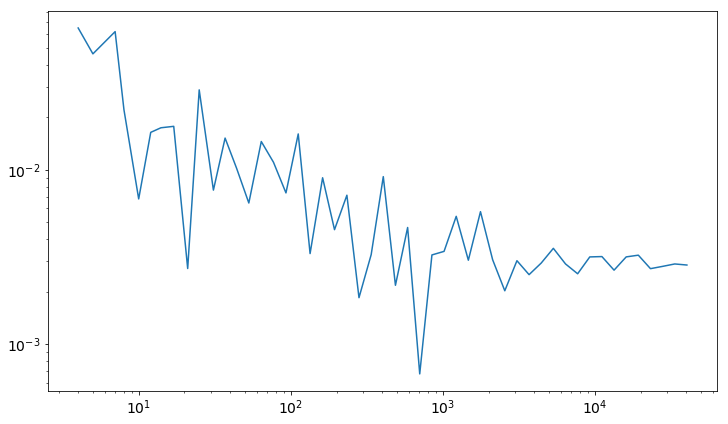

In [26]:
plt.loglog(Ns, errs)

В окрестности N=1000, поведение ошибки выходит на константу, что уже не связано с ростом числа спутников, а скорее с машиннной ошибкой. Поэтому исследуем только до N=1000.

In [27]:
slope, intercept = np.polyfit(np.log(Ns[:29]), np.log(errs[:29]), 1)
print('slope = ', slope)
print('intercept = ', intercept)

slope =  -0.51447742899
intercept =  -2.61054007777


$Err \propto \frac{1}{\sqrt{N}}$ 

Данный результат прекрасно согласуется с ЦПТ.